In [ ]:

# coding: utf-8



In [1]:




import os
import glob
from os.path import dirname, abspath
import sys
import datetime
import random
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('QT5Agg')
from cucu_genDatasetClass import *
from cucu_realDatasetClass import *

import json

ROOT_DIR = os.path.abspath("../")


# ROOT_DIR = dirname(dirname(os.path.realpath(__file__)))
print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "cucu_train/weightsAndGraphs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
  




/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/simon/anaconda3/envs/cucuEnv/

/home/simon/Mask_RCNN


Using TensorFlow backend.


In [2]:





class cucumberConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cucumbers"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    # IMAGES_PER_GPU = 2
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + cucumber, leaf, flower

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM =512
    
    # anchor side in pixels, for each of RPN layer
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  
       
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    
    #asher todo: can we utilize it better?
    #ROI_POSITIVE_RATIO = 66  
    
    #asher todo: enlarge to 100 when real training occures
    STEPS_PER_EPOCH = 10

    VALIDATION_STEPS = 2
     # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = cucumberConfig()
config.display()







Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [4]:



# Training dataset
# asher todo: add a choice from which dataset to generate
# dataset_train = realDataset()
# dataset_train.load_image(ROOT_DIR + '/cucu_train/real_annotations/segmentation_results.json',ROOT_DIR + "/cucu_train/real_images_and_annotations")
# asher todo: finish new classes calls
dataset_train = genDataset( ROOT_DIR + '/cucu_train/cucumbers_objects', 
                            ROOT_DIR + '/cucu_train/leaves_objects',
                            ROOT_DIR + '/cucu_train/flower_objects',
                        ROOT_DIR + '/cucu_train/background_folder', config)
dataset_train.load_shapes(100, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = genDataset( ROOT_DIR + '/cucu_train/cucumbers_objects', 
                            ROOT_DIR + '/cucu_train/leaves_objects',
                            ROOT_DIR + '/cucu_train/flower_objects',
                        ROOT_DIR + '/cucu_train/background_folder', config)
dataset_val.load_shapes(20, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()





folder: /home/simon/Mask_RCNN/cucu_train/cucumbers_objects inited
folder: /home/simon/Mask_RCNN/cucu_train/background_folder inited
folder: /home/simon/Mask_RCNN/cucu_train/cucumbers_objects inited
folder: /home/simon/Mask_RCNN/cucu_train/background_folder inited


(512, 512, 3)


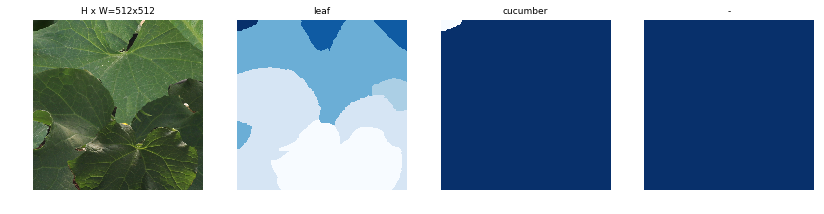

(512, 512, 3)


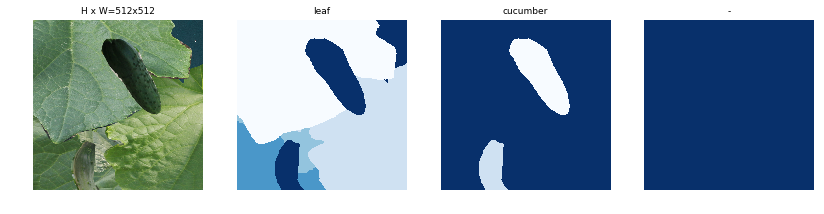

(512, 512, 3)


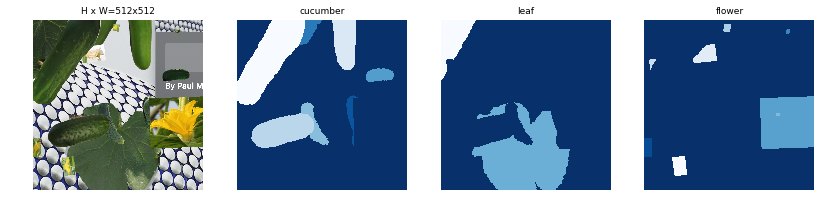

(512, 512, 3)


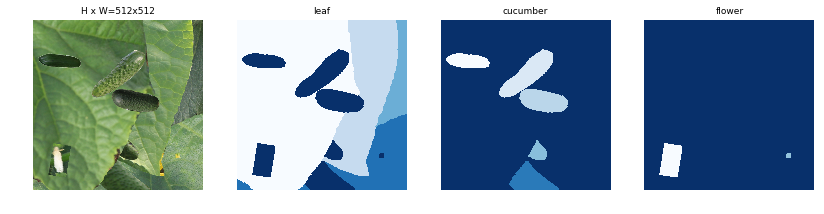

(512, 512, 3)


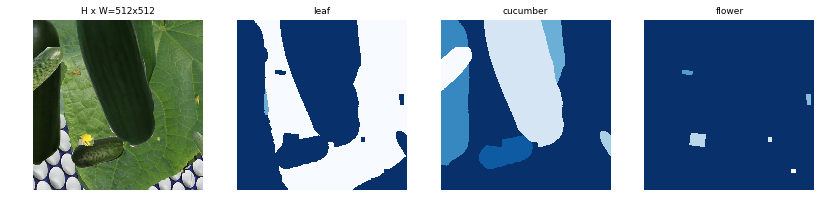

In [5]:



# asher todo: change code to fit new load_image method of coco
#show n random image&mask train examples
n = 5
image_ids = np.random.choice(dataset_train.image_ids, n)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, 3)



# # # In[9]:



# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)






In [ ]:



# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "cucumber":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(MODEL_DIR + "/cucuWheights_2018-12-22 17:17:10.830997.h5", by_name=True)






In [ ]:


# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
#asher note: each time only one sort of train is possible as for now.
# model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')





In [ ]:


#asher todo: make for loop on generated and real data set
model.train(dataset_train, dataset_val, learning_rate= config.LEARNING_RATE, epochs=3000, layers="all")





In [ ]:


# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
now = datetime.datetime.now()
model_path = os.path.join(MODEL_DIR, "cucuWheights_" + str(now) + ".h5")
model.keras_model.save_weights(model_path)





In [ ]:


# list_of_files = glob.glob(MODEL_DIR +'/*')
# latest_file = max(list_of_files, key=os.path.getctime)


# # In[ ]:



# # Training dataset
# # asher todo: add a choice from which dataset to generate
# # dataset_train = realDataset()
# # dataset_train.load_image(ROOT_DIR + '/cucu_train/real_annotations/segmentation_results.json',ROOT_DIR + "/cucu_train/real_images_and_annotations")
# dataset_train = genDataset( ROOT_DIR + '/cucu_train/object_folder', ROOT_DIR + '/cucu_train/background_folder', config)
# dataset_train.load_shapes(200, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
# dataset_train.prepare()

# # Validation dataset
# dataset_val = genDataset( ROOT_DIR + '/cucu_train/object_folder', ROOT_DIR + '/cucu_train/background_folder', config)
# dataset_val.load_shapes(20, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
# dataset_val.prepare()
# # In[1]
# list_of_files = glob.glob(MODEL_DIR)
# latest_file = max(list_of_files, key=os.path.getctime)
# model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
# model.load_weights(MODEL_DIR + '/' + latest_file, by_name=True)
# model.train(dataset_train, dataset_val, learning_rate= config.LEARNING_RATE, epochs=30, layers="all")
# # Save weights
# # Typically not needed because callbacks save after every epoch
# # Uncomment to save manually
# now = datetime.datetime.now()
# model_path = os.path.join(MODEL_DIR, "cucuWheights_" + str(now) + ".h5")
# model.keras_model.save_weights(model_path)




In [ ]:


class InferenceConfig(cucumberConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(MODEL_DIR, "cucuWheights_2018-12-22 17:17:10.830997.h5")
# model_path = model.find_last()


# Load trained weights
print("Loading weights from ", latest_file)
model.load_weights(latest_file, by_name=True)





In [ ]:


def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


tests_location = ROOT_DIR + "/cucu_train/simple_test/"
for filename in sorted(os.listdir(tests_location)):
    
    testImage = os.path.join(tests_location,filename)
    t = cv2.cvtColor(cv2.imread(testImage), cv2.COLOR_BGR2RGB)
    results = model.detect([t], verbose=1)
    r = results[0]
    visualize.display_instances(t, r['rois'], r['masks'], r['class_ids'] ,dataset_train.class_names, r['scores'], ax=get_ax())
    t= dataset_train.class_names
    print(t)

#asher todo: get inspiration from this later
# # In[28]:






In [ ]:




# # Compute VOC-Style mAP @ IoU=0.5
# # Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 100)
# APs = []
# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask =        modellib.load_image_gt(dataset_val, inference_config,
#                                image_id, use_mini_mask=False)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
#     # Run object detection
#     results = model.detect([image], verbose=0)
#     r = results[0]
#     # Compute AP
#     AP, precisions, recalls, overlaps =        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
#     APs.append(AP)
    
# print("mAP: ", np.mean(APs))






